# TL;DR

The goal of this notebook is to visualize COVID-19 infections using data from https://github.com/CSSEGISandData/COVID-19.

Most illustrative plots of how the pandemic is being controlled:
- [Relative increases per day by country](#country_relative_increases)
- [Relative increases per day by state](#us_state_relative_increases)

Visualizations found in this notebook:
- [Top 20 countries by cumulative confirmed COVID-19 cases](#top_countries_confirmed)
- [Top 10 countries by NEW confirmed COVID-19 cases](#top_countries_confirmed_new)
- [Time-series plots of infections in most infected countries](#time-series_countries)
- [Forecasts of infections/deaths 1 and 7 days in the future](#forecasts_countries)
- [Relative increases per day by country](#country_relative_increases)
- [Time-series plots of mortality](#time-series_country_mortality)
- [Mortality as currently measured, compared to expected based on WHO mortality expectations](#counry_mortality_expectations)
  - [Source of expectations](http://weekly.chinacdc.cn/en/article/id/e53946e2-c6c4-41e9-9a9b-fea8db1a8f51)
- [Density of infections per million people](#density_of_infections_by_country)
- [How many days behind is each country from Italy?](#days_behind)
- [US states with the most new infections](#states_most_infections)
- [Time-series plots of infections in most-infected states](#time-series_states)
- [State forecasts of infections/deaths 1 and 7 days in the future](#forecast_us_state)
- [States and their daily increase fraction in confirmed cases/deaths](#us_state_daily_increase_fraction)
- [Compare US state infections against Washington](#state_infections_vs_wa)
- [Compare US state infections against New York](#state_infections_vs_ny)
- [Mortality rate by US state](#mortality_by_us_state)
- [Relative increases per day by state](#us_state_relative_increases)

In [1]:


from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')



# Imports and definitions

In [51]:
import pandas as pd
import numpy as np
import os
import datetime
import re
from dateutil import parser
from matplotlib import pyplot as plt
import warnings

plt.rcParams['figure.figsize'] = 12,6
#plt.style.use('seaborn-dark-palette')
plt.style.use('seaborn-darkgrid')
pd.options.display.max_columns = 300

def datetime_to_unixtime(dt):
    return (dt - datetime.datetime(1970, 1, 1)).total_seconds()

# Load data

In [52]:
# define paths to each raw file
d_ts = {}
#d_ts['confirmed'] = '../COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv'
#d_ts['deaths'] = '../COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv'
d_ts['confirmed'] = '../COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
d_ts['deaths'] = '../COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'

#d_ts['recovered'] = '../COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Recovered.csv'

# load in each CSV
d_data = {}
for key, file_path in d_ts.items():
    d_data[key] = pd.read_csv(file_path)

# Clean to long form

In [53]:
def clean_wide_to_long(dfp, key):
    # find columns with dates in them
    cols = list(dfp.columns)
    date_cols = [col for col in cols if re.findall('(\d+/\d+/\d+)', col)]  #if '/' in col
    non_date_cols = list(set(cols) - set(date_cols))
    
    # wide to long
    dfp_melt = pd.melt(dfp, id_vars=non_date_cols, value_vars=date_cols)
    dfp_melt = dfp_melt.rename(columns={'variable': 'date', 
                                        'value': key,
                                        'Country/Region': 'country',
                                        'Province/State': 'state',
                                       })
    dfp_melt['date'] = dfp_melt['date'].apply(parser.parse)
    dfp_melt[key] = dfp_melt[key].apply(float)
    return dfp_melt

In [54]:
# convert from wide to long form
d_dfps = {}
dfp = None
merge_cols = ['country', 'state', 'date']
for key, dfp_wide in d_data.items():
    print(f'metric: {key} at {datetime.datetime.now()}')
    d_dfps[key] = clean_wide_to_long(dfp_wide, key)
    
    if dfp is None:
        dfp = d_dfps[key].copy()
    else:
        dfp_temp = d_dfps[key][merge_cols + [key]]
        dfp = dfp.merge(dfp_temp, on=merge_cols, how='left')
        
print(f"Latest data from {dfp['date'].max().strftime('%Y-%m-%d')}")

metric: confirmed at 2020-03-28 20:55:47.561687
metric: deaths at 2020-03-28 20:55:48.251247
Latest data from 2020-03-28


In [6]:
# # TEMP FIX - There are data issues on 2020-03-18; these are corrections that will hopefully be fixed
# state_fixes_20200318 = {'New York': 3083, 
#                         'Washington': 1187, 
#                         'California': 870, 
#                         'Florida': 330, 
#                         'New Jersey': 427, 
#                         'Louisiana': 280}
# for state, val in state_fixes_20200318.items():
#     dfp.loc[(dfp.country == 'US') & 
#             (dfp['date'] == datetime.datetime(2020,3,18)) & 
#             (dfp.state == state), 'confirmed'] = val

In [55]:
# aggregate by country (the US data is reported by state)
dfp_country = (dfp.groupby(['date', 'country'], as_index=False).
               agg({
                   'confirmed': np.sum,
                   'deaths': np.sum,
                   #'recovered': np.sum,
               }))
#dfp_country['active'] = dfp_country['confirmed'] - dfp_country['recovered']
dfp_country['confirmed_lag1'] = dfp_country.groupby(['country'])['confirmed'].shift(1)
dfp_country['confirmed_new'] = dfp_country['confirmed'] - dfp_country['confirmed_lag1']
dfp_country['deaths_lag1'] = dfp_country.groupby(['country'])['deaths'].shift(1)
dfp_country['deaths_new'] = dfp_country['deaths'] - dfp_country['deaths_lag1']
dfp_country['mortality_rate'] = dfp_country['deaths'] / dfp_country['confirmed']

<a id='top_countries_confirmed'></a>
##### Top 20 countries by cumulative confirmed COVID-19 cases

In [56]:
# get the top countries
id_cols = ['date', 'country']
value_cols = [
    'confirmed',
    'confirmed_new',
    'deaths',
    'deaths_new',
    #'active',
    'mortality_rate',
]
dfp_top_countries = dfp_country[dfp_country['date'] == dfp_country['date'].max()][id_cols + value_cols]
dfp_top_countries = dfp_top_countries.sort_values(by='deaths', ascending=0).reset_index(drop=True)
for key in value_cols:
    if 'rate' in key:
        continue
    dfp_top_countries[key] = dfp_top_countries[key].apply(int)
dfp_top_countries.head(20)

,date,country,confirmed,confirmed_new,deaths,deaths_new,mortality_rate
0,2020-03-28,Italy,92472,5974,10023,889,0.108390
1,2020-03-28,Spain,73235,7516,5982,844,0.081682
2,2020-03-28,China,81999,102,3299,3,0.040232
3,2020-03-28,Iran,35408,3076,2517,139,0.071086
4,2020-03-28,France,38105,4703,2317,320,0.060806
5,2020-03-28,US,121478,19821,2026,445,0.016678
6,2020-03-28,United Kingdom,17312,2567,1021,260,0.058976
7,2020-03-28,Netherlands,9819,1172,640,93,0.065180
8,2020-03-28,Germany,57695,6824,433,91,0.007505
9,2020-03-28,Belgium,9134,1850,353,64,0.038647


<a id='top_countries_confirmed_new'></a>
##### Top 10 countries by NEW confirmed COVID-19 cases

In [57]:
dfp_top_countries.sort_values(by='confirmed_new', ascending=0).head(10)

,date,country,confirmed,confirmed_new,deaths,deaths_new,mortality_rate
5,2020-03-28,US,121478,19821,2026,445,0.016678
1,2020-03-28,Spain,73235,7516,5982,844,0.081682
8,2020-03-28,Germany,57695,6824,433,91,0.007505
0,2020-03-28,Italy,92472,5974,10023,889,0.108390
4,2020-03-28,France,38105,4703,2317,320,0.060806
3,2020-03-28,Iran,35408,3076,2517,139,0.071086
6,2020-03-28,United Kingdom,17312,2567,1021,260,0.058976
9,2020-03-28,Belgium,9134,1850,353,64,0.038647
13,2020-03-28,Turkey,7402,1704,108,16,0.014591
7,2020-03-28,Netherlands,9819,1172,640,93,0.065180


<a id='time-series_countries'></a>
# Time-series plots of infections in most infected countries

In [58]:
def plot_countries(
    dfp_country,
    countries=dfp_top_countries.iloc[:10]['country'],
    plot_cols=['confirmed', 'deaths', 'recovered', 'active', 'confirmed_new'],
    country_col='country',
    n_columns=2,
    y_min=1,
    y_max=dfp_top_countries['confirmed'].max() * 1.5,
    date_col='date',
    y_label='num_cases',
    date_min=datetime.datetime(2020,2,1),    
):
    i = 1
    n_rows = int(np.ceil(len(countries) / n_columns))
    plt.figure(figsize=(12,24))
    
    for country in countries:
        dfp_plot = dfp_country[(dfp_country[country_col] == country) &
                               (dfp_country[date_col] >= date_min)
                              ]
        dfp_plot = dfp_plot[dfp_plot['confirmed_new'] != 0]
        plt.subplot(n_rows, n_columns, i)
        for key in plot_cols:
            plt.plot(dfp_plot[date_col], dfp_plot[key], alpha=0.7, label=key)
        plt.legend(loc='best')
        plt.ylabel(f'{y_label}')
        plt.title(f'{country_col}: {country}')
        plt.yscale('log')
        plt.ylim([y_min, y_max])
        plt.xticks(rotation=90)

        i += 1
    plt.tight_layout()
    plt.show()

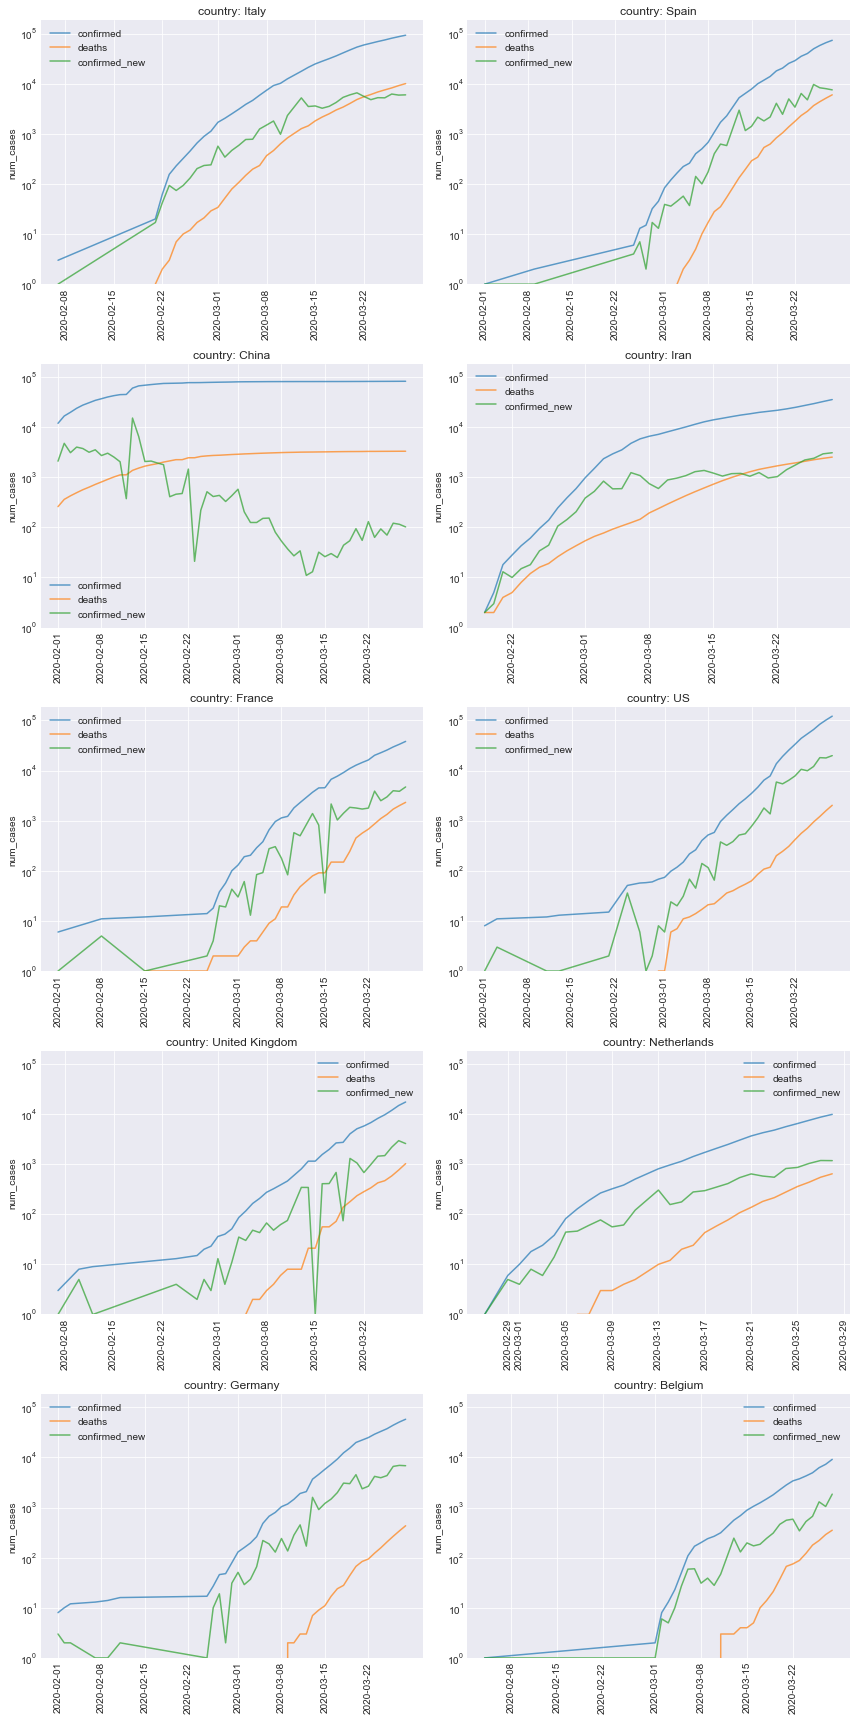

In [59]:
n_countries = 10

plot_countries(dfp_country, 
               countries=dfp_top_countries.iloc[:n_countries]['country'],
               plot_cols=['confirmed', 'deaths', 'confirmed_new'], #, 'recovered', 'active'
               country_col='country'
              )

<a id='forecasts_countries'></a>
# Forecasts of infections/deaths 1 and 7 days in the future

For confirmed cases (`confirmed_pred`) and deaths (`deaths_pred`)

In [60]:
def predict_from_fit(row):
    return int(10**(row['slope'] * row['unixtime'] + row['intercept']))

def shift_future(dfp, days=1):
    dfp_most_recent = dfp.copy()
    dfp_most_recent['date'] = dfp_most_recent['date'] + datetime.timedelta(days=days)
    dfp_most_recent['unixtime'] = dfp_most_recent['unixtime'] + 86400 * days
    
    for col in ['confirmed', 'deaths', 'recovered', 'active', 'confirmed_lag1', 'confirmed_new', 'deaths_new']:
        dfp_most_recent[col] = np.nan
    return dfp_most_recent

def fit_poly1(dfp_country_recent, 
              col_fit='confirmed_log', 
              col_pred='confirmed_pred', 
              date_most_recent=None,
              col_locale='country'
             ):
    warnings.simplefilter('ignore', np.RankWarning)
    if date_most_recent is None:
        date_most_recent = dfp_country_recent['date'].max()
    dfp_country_recent = dfp_country_recent.set_index(col_locale)
    
    # fit
    dfp_country_recent_clean = dfp_country_recent[(dfp_country_recent['date'] <= date_most_recent) &
                                                  (dfp_country_recent[col_fit] > 0)
                                                 ]
    dfp_country_confirmed_fit = (dfp_country_recent[dfp_country_recent['date'] <= date_most_recent].
                                 groupby([col_locale]).
                                 apply(lambda x: np.polyfit(x['unixtime'], x[col_fit], 1))
                                )
    dfp_country_recent['fits'] = dfp_country_confirmed_fit
    dfp_country_recent[['slope', 'intercept']] = dfp_country_recent['fits'].apply(pd.Series)   
    
    dfp_country_recent[col_pred] = dfp_country_recent.apply(predict_from_fit, axis=1)
    dfp_country_recent = dfp_country_recent.drop(columns=['fits', 'intercept']).reset_index() #'slope', 
    fit_col = col_fit.split('_')[0]
    dfp_country_recent[f"frac_increase_{fit_col}"] = (10**(dfp_country_recent['slope'] * 86400) - 1)
    #dfp_country_recent = dfp_country_recent.rename(columns={'slope': f'slope_{col_fit.split("_")[0]}'})
    return dfp_country_recent, dfp_country_confirmed_fit

def fit_exp(dfp_country, 
            n_days_predict=14, 
            n_days_into_future=[1,7],
            col_locale='country', 
            top_countries=None, 
            n_countries=10, 
            date_most_recent=None,
            is_silent=False
           ):
    # make predictions based on the last 2 weeks of data
    if date_most_recent is None:
        date_most_recent = dfp_country['date'].max()
    date_n_days_ago = date_most_recent - datetime.timedelta(days=n_days_predict-1)
    dfp_country_recent = (dfp_country[dfp_country['date'].between(date_n_days_ago, date_most_recent)].
                          sort_values(by=[col_locale, 'date'])
                         ).copy()

    # clean data for fit (convert to log)
    dfp_country_recent['confirmed_log'] = dfp_country_recent['confirmed'].apply(lambda x: np.log10(x) if x > 0 else 0)
    dfp_country_recent['deaths_log'] = dfp_country_recent['deaths'].apply(lambda x: np.log10(x) if x > 0 else 0)
    dfp_country_recent['unixtime'] = dfp_country_recent['date'].apply(datetime_to_unixtime)
    
    
    # make predictions to past, then future
    # add in future points
    dfp_most_recent = dfp_country_recent[dfp_country_recent['date'] == date_most_recent].copy()
    list_dfp_recent = [dfp_country_recent]
    for n in n_days_into_future:
        dfp_most_recent_tmp = shift_future(dfp_most_recent, n)
        list_dfp_recent.append(dfp_most_recent_tmp)
    #dfp_most_recent_7 = shift_future(dfp_most_recent, 7)
    #dfp_country_recent = pd.concat([dfp_country_recent, dfp_most_recent_1, dfp_most_recent_7], axis=0, sort=False)
    dfp_country_recent = pd.concat(list_dfp_recent, axis=0, sort=False)
    dfp_country_recent, dfp_country_deaths_fit = fit_poly1(dfp_country_recent, 
                                                           col_fit='deaths_log', 
                                                           col_pred='deaths_pred', 
                                                           col_locale=col_locale, 
                                                           date_most_recent=date_most_recent
                                                          )
    dfp_country_recent, dfp_country_confirmed_fit = fit_poly1(dfp_country_recent, 
                                                              col_fit='confirmed_log', 
                                                              col_pred='confirmed_pred', 
                                                              col_locale=col_locale, 
                                                              date_most_recent=date_most_recent
                                                             )
    dfp_country_recent['mortality_rate_pred'] = dfp_country_recent['deaths_pred'] / dfp_country_recent['confirmed_pred']

    # look only at the predictions for top countries
    if top_countries is None:
        top_countries = (dfp_most_recent.
                         sort_values(by='deaths', ascending=0).iloc[:n_countries][col_locale].values)
    dfp_forecasts = dfp_country_recent[(dfp_country_recent['date'] > date_most_recent)
                                       
                                      ].sort_values(by=[col_locale, 'date']).reset_index(drop=True)
    dfp_forecasts_out = dfp_forecasts[['date', 
                                       col_locale, 
                                       'confirmed_pred', 
                                       'deaths_pred', 
                                       'mortality_rate_pred', 
                                       'frac_increase_confirmed', 
                                       'frac_increase_deaths'
                                      ]].copy()
    dfp_forecasts_out['date'] = dfp_forecasts_out['date'].apply(lambda x: x.strftime('%Y-%m-%d'))

    # find the daily fractional increase in cases
    dfp_frac_increase = (dfp_forecasts_out.
                         groupby([col_locale]).
                         agg({'frac_increase_confirmed': np.mean, 
                              'frac_increase_deaths': np.mean}))
    dfp_frac_increase.columns = pd.MultiIndex.from_product([dfp_frac_increase.columns, ['']])

    # pivot so each date of prediction has its own column
    dfp_forecasts_print = dfp_forecasts_out.pivot(index=col_locale, 
                                                  columns='date', 
                                                  values=['confirmed_pred', 'deaths_pred', 'mortality_rate_pred']
                                                 ).sort_values(by=('deaths_pred', dfp_forecasts_out['date'].min()), ascending=0)
    dfp_forecasts_print = dfp_forecasts_print.merge(dfp_frac_increase, on=col_locale, how='inner')
    if not is_silent:
        display(dfp_forecasts_print[dfp_forecasts_print.index.isin(top_countries)])
    return dfp_country_recent, dfp_forecasts_out


def plot_forecasts(dfp_country_recent, 
                   n_countries=10, 
                   n_columns=2, 
                   figsize=(12,24), 
                   date_min=datetime.datetime(2020, 2, 1),
                   col_locale='country',
                  ):
    # subset the top countries
    dfp_non_pred = dfp_country_recent.dropna(subset=['deaths'])
    dt_max = dfp_non_pred['date'].max()
    dfp_top_countries = (dfp_non_pred[dfp_non_pred['date'] == dt_max].
                         sort_values(by='deaths', ascending=0).
                         iloc[:n_countries]
                        )
    top_countries = (dfp_top_countries.
                     iloc[:n_countries][col_locale].values
                    )

    # plot the top countries
    i = 1
    n_rows = int(np.ceil(n_countries / n_columns))
    plt.figure(figsize=figsize)
    y_max = dfp_country_recent['confirmed_pred'].max()
    y_min = max(dfp_country_recent['deaths'].min(), 1)

    for country in top_countries:
        dfp_plot = dfp_country_recent[(dfp_country_recent[col_locale] == country) &
                               (dfp_country_recent['date'] >= date_min)
                              ].sort_values(by='date')
        plt.subplot(n_rows, n_columns, i)
        for key in ['confirmed', 'deaths']:
            p = plt.plot(dfp_plot['date'], dfp_plot[key], alpha=0.5, linewidth=2, label=key)
            pred_col = f'{key}_pred'
            plt.plot(dfp_plot['date'], dfp_plot[pred_col], linestyle='--', linewidth=2, alpha=0.5, color=p[0].get_color(), label=pred_col)
        plt.legend(loc='best')
        plt.ylabel('num cases')
        plt.title(f'{col_locale}: {country}')
        plt.yscale('log')
        plt.ylim([y_min, y_max])
        plt.xticks(rotation=90)

        i += 1
    plt.tight_layout()
    plt.show()
    return None
                       
                       
def save_forecast(dfp_forecasts_out, dfp_country_recent, n_days_training=14):
    date_most_recent = dfp_country_recent.dropna(subset=['deaths'])['date'].max()
    dfp_forecasts_out['date_of_forecast'] = date_most_recent
    save_name = f"covid-19_country_forecast_from_{date_most_recent.strftime('%Y-%m-%d')}_n_days_training={n_days_training}.csv"
    save_path = os.path.join('predictions', save_name)
    dfp_forecasts_out.to_csv(save_path, index=False)
    print(f'saved forecast to {save_path}')
    return None

##### Forecasts based on last 1 week

confirmed_pred                        deaths_pred             \
date               2020-03-29 2020-04-04  2020-04-18  2020-03-29 2020-04-04   
country                                                                       
Italy                100319.0   157283.0    449137.0     11145.0    20372.0   
Spain                 89617.0   231376.0   2115815.0      7739.0    26190.0   
China                 82078.0    82657.0     84024.0      3304.0     3332.0   
France                44223.0   100670.0    686242.0      3010.0    10449.0   
Iran                  38028.0    62575.0    200035.0      2715.0     4072.0   
US                   155297.0   563097.0  11373572.0      2661.0    12903.0   
United Kingdom        20904.0    64369.0    887900.0      1159.0     4025.0   
Netherlands           11428.0    27042.0    201756.0       828.0     3083.0   
Germany               66657.0   154766.0   1104796.0       567.0     2632.0   
Belgium               10254.0    27920.0    289003.0       487.0     2491.0   

                          mortality_rate_pred                        \
date           2020-04-18          2020-03-29 2020-04-04 2020-04-18   
country                                                               
Italy             83221.0            0.111096   0.129524   0.185291   
Spain            450307.0            0.086356   0.113192   0.212829   
China              3398.0            0.040254   0.040311   0.040441   
France           190691.0            0.068064   0.103795   0.277877   
Iran              10486.0            0.071395   0.065074   0.052421   
US               513292.0            0.017135   0.022914   0.045130   
United Kingdom    73553.0            0.055444   0.062530   0.082839   
Netherlands       66216.0            0.072454   0.114008   0.328198   
Germany           94357.0            0.008506   0.017006   0.085407   
Belgium          112187.0            0.047494   0.089219   0.388186   

               frac_increase_confirmed frac_increase_deaths  
date                                                         
country                                                      
Italy                         0.077829             0.105748  
Spain                         0.171262             0.225293  
China                         0.001173             0.001403  
France                        0.146941             0.230515  
Iran                          0.086551             0.069898  
US                            0.239472             0.300949  
United Kingdom                0.206163             0.230624  
Netherlands                   0.154359             0.244912  
Germany                       0.150726             0.291318  
Belgium                       0.181678             0.312527

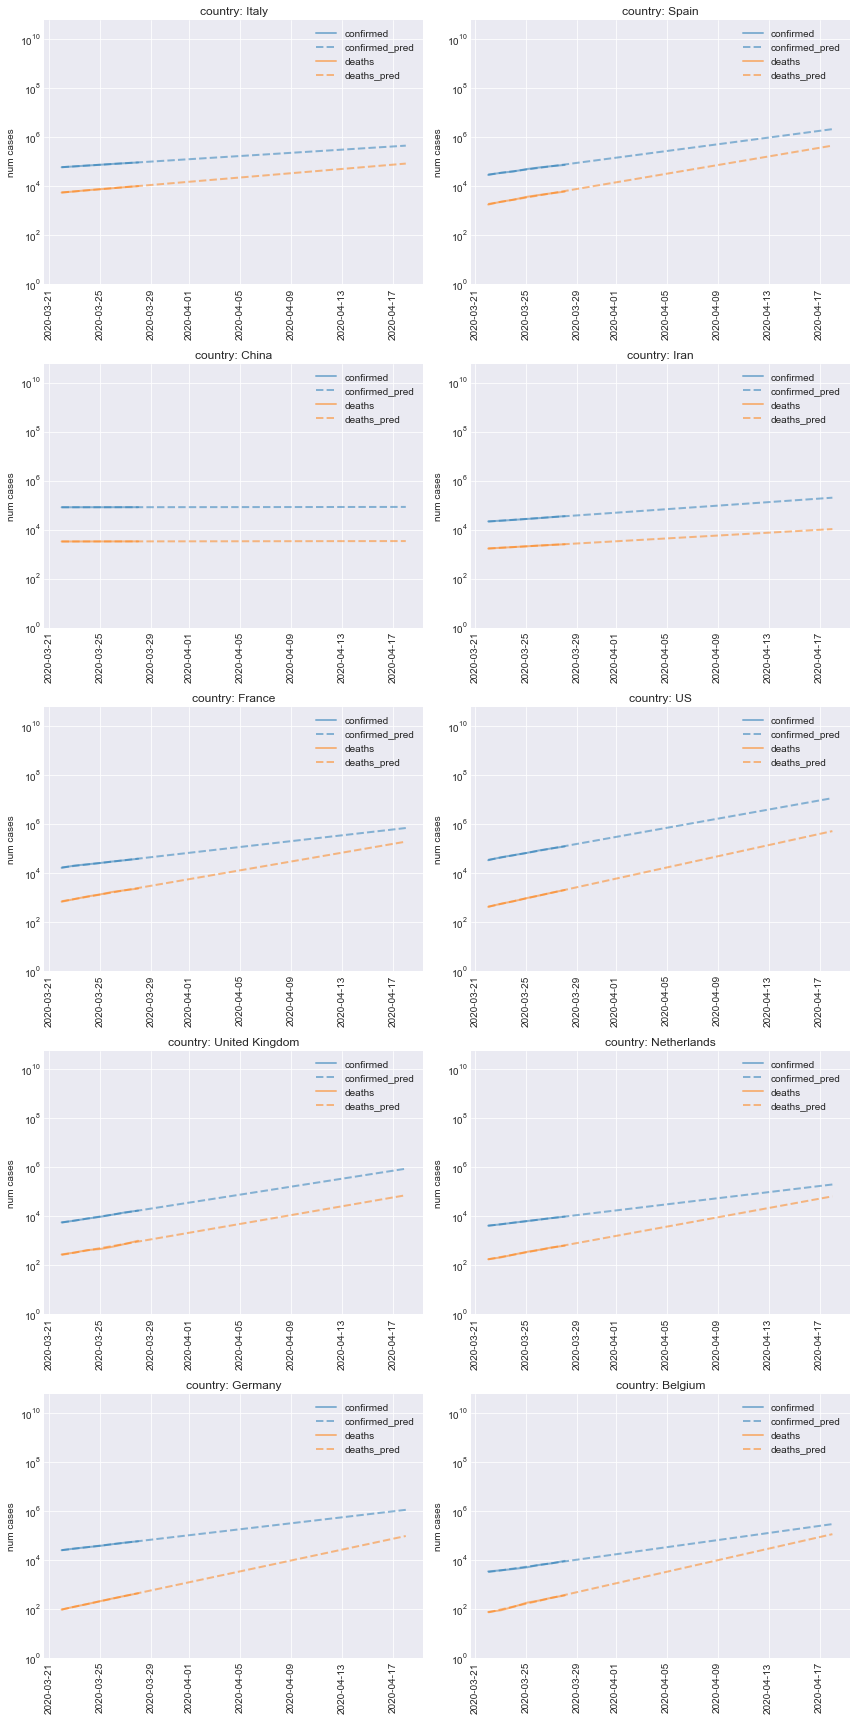

In [61]:
dfp_country_recent_1, dfp_forecasts_out_1 = fit_exp(dfp_country, 
                                                    n_days_predict=7,
                                                    n_days_into_future=[1,7,21], 
                                                    col_locale='country', 
                                                    top_countries=None
                                                   )
plot_forecasts(dfp_country_recent_1)

In [62]:
save_forecast(dfp_forecasts_out_1, dfp_country_recent_1, 7)

saved forecast to predictions/covid-19_country_forecast_from_2020-03-28_n_days_training=7.csv


<a id='country_relative_increases'></a>
### Relative increases per day by country

In [63]:
def find_relative_increase_data_and_plot(dfp_us_g, 
                                         n_days_fit=7, 
                                         dt=datetime.datetime(2020,3,10),
                                         n_locales=7,
                                         col_locale='state'
                                        ):
    dt_max = dfp_us_g['date'].max()
    list_dfp_state_relative = []
    while dt <= dt_max:
        try:
            dfp_state_recent_tmp, dfp_state_forecasts_out_tmp = fit_exp(dfp_us_g, 
                                                                        n_days_predict=n_days_fit, 
                                                                        col_locale=col_locale, 
                                                                        top_countries=None,
                                                                        date_most_recent=dt,
                                                                        is_silent=True
                                                                       )
            dfp_state_recent_tmp = dfp_state_recent_tmp.dropna(subset=['confirmed'])
            dfp_state_recent_tmp_single = dfp_state_recent_tmp[dfp_state_recent_tmp['date'] == dfp_state_recent_tmp['date'].max()]
            list_dfp_state_relative.append(dfp_state_recent_tmp_single)
        except Exception as e:
            print(f"failed on {dt.strftime('%Y-%m-%d')}")

        dt += datetime.timedelta(days=1)
    dfp_state_relative_chng = pd.concat(list_dfp_state_relative)
                  
    # plot states
    top_states = (dfp_state_relative_chng[(dfp_state_relative_chng['date'] == dfp_state_relative_chng['date'].max())].
                  sort_values(by='deaths', ascending=0).
                  reset_index(drop=True).
                  iloc[:n_locales][col_locale].values
                 )
                  
    # deaths
    plt.subplot(1,2,1)
    for state in top_states:
        dfp_st = dfp_state_relative_chng[(dfp_state_relative_chng[col_locale] == state) & 
                                         (dfp_state_relative_chng['deaths'] > 2)]
        #
        plt.plot(dfp_st['date'], dfp_st['frac_increase_deaths'], label=state, alpha=0.7)
        plt.ylabel('relative increase in deaths')
        plt.xticks(rotation=90)
        plt.legend(loc='best')
        plt.axhline(0, color='k', alpha=0.5)
        plt.title('Relative daily increase in deaths')

    # confirmed cases
    plt.subplot(1,2,2)
    for state in top_states:
        dfp_st = dfp_state_relative_chng[(dfp_state_relative_chng[col_locale] == state) & 
                                         (dfp_state_relative_chng['deaths'] > 2)]
        
        plt.plot(dfp_st['date'], dfp_st['frac_increase_confirmed'], label=state, alpha=0.7)
        plt.ylabel('relative increase in confirmed')
        plt.xticks(rotation=90)
        plt.legend(loc='best')
        plt.axhline(0, color='k', alpha=0.5)
        plt.title('Relative daily increase in confirmed')

    plt.show()
    return None


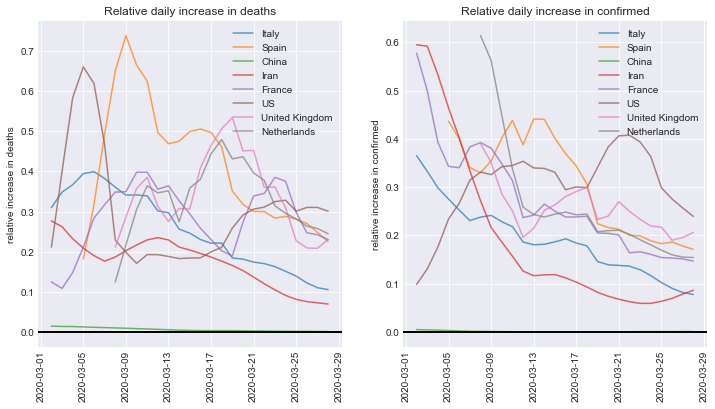

In [64]:
find_relative_increase_data_and_plot(dfp_country, n_locales=8, col_locale='country', dt=datetime.datetime(2020,3,2))

##### Forecasts based on last 2 weeks

confirmed_pred            deaths_pred             \
date               2020-03-29 2020-04-04  2020-03-29 2020-04-04   
country                                                           
Italy                112051.0   207624.0     12626.0    27900.0   
Spain                 95489.0   270141.0      8896.0    37561.0   
France                47563.0   119387.0      3653.0    17212.0   
China                 82005.0    82484.0      3314.0     3357.0   
Iran                  36106.0    54393.0      3014.0     5237.0   
US                   201610.0  1086828.0      2717.0    13693.0   
United Kingdom        22524.0    76259.0      1505.0     7423.0   
Netherlands           12464.0    33413.0      1015.0     5059.0   
Belgium               10698.0    30932.0       685.0     5655.0   
Germany               76891.0   215459.0       626.0     3247.0   

               mortality_rate_pred            frac_increase_confirmed  \
date                    2020-03-29 2020-04-04                           
country                                                                 
Italy                     0.112681   0.134378                0.108264   
Spain                     0.093163   0.139042                0.189248   
France                    0.076803   0.144170                0.165771   
China                     0.040412   0.040699                0.000970   
Iran                      0.083476   0.096281                0.070682   
US                        0.013477   0.012599                0.324162   
United Kingdom            0.066818   0.097339                0.225391   
Netherlands               0.081435   0.151408                0.178620   
Belgium                   0.064031   0.182820                0.193563   
Germany                   0.008141   0.015070                0.187356   

               frac_increase_deaths  
date                                 
country                              
Italy                      0.141267  
Spain                      0.271324  
France                     0.294754  
China                      0.002170  
Iran                       0.096415  
US                         0.309367  
United Kingdom             0.304647  
Netherlands                0.306792  
Belgium                    0.421400  
Germany                    0.315337

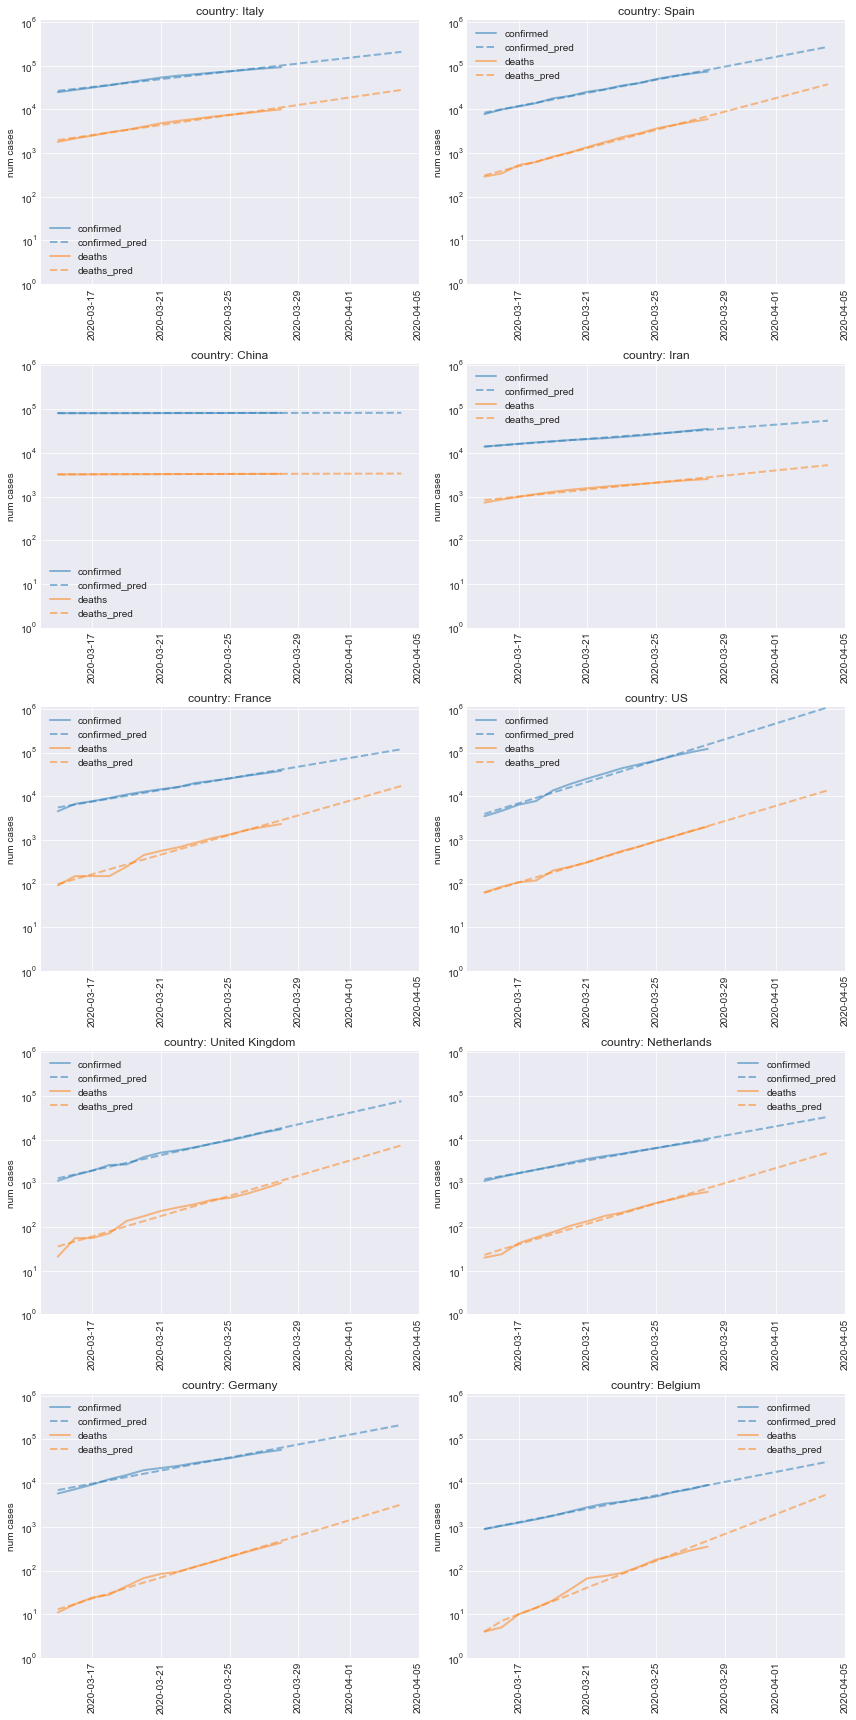

In [65]:
dfp_country_recent_2, dfp_forecasts_out_2 = fit_exp(dfp_country, 
                                                    n_days_predict=14, 
                                                    col_locale='country', 
                                                    top_countries=None
                                                   )
plot_forecasts(dfp_country_recent_2)

In [66]:
save_forecast(dfp_forecasts_out_2, dfp_country_recent_2, 14)

saved forecast to predictions/covid-19_country_forecast_from_2020-03-28_n_days_training=14.csv


<a id='time-series_country_mortality'></a>
# Time-series plots of mortality

In [67]:
def plot_mortality_rate(
    dfp, 
    locales, 
    id_col='country', 
    upper_lim=0.2, 
    date_min=datetime.datetime(2020,2,20),
    dfp_country_mortality_expected=None
):
    
    for locale in locales:
        dfp_plot = dfp[(dfp[id_col] == locale) &
                       (dfp['date'] >= date_min)
                      ]
        p = plt.plot(dfp_plot['date'], dfp_plot['mortality_rate'], label=locale, alpha=0.7)
        
        if dfp_country_mortality_expected is not None:
            dfp_expected = dfp_country_mortality_expected[dfp_country_mortality_expected['country'] == locale]
            
            color = p[0].get_color()
            expected = dfp_expected['frac_mortality'].values[0]
            plt.axhline(expected, 
                        color=color, 
                        alpha=0.5, 
                        linestyle='--', 
                        label=f'{locale} expected = {expected:0.4f}'
                       )
    #plt.legend(loc='best')
    plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1)
    if upper_lim is not None:
        plt.ylim([0,upper_lim])
    #plt.yscale('log')
    plt.ylabel('mortality rate')
    plt.title(f'Mortality by {id_col}')
    plt.xticks(rotation=90)
    plt.show()
    return None

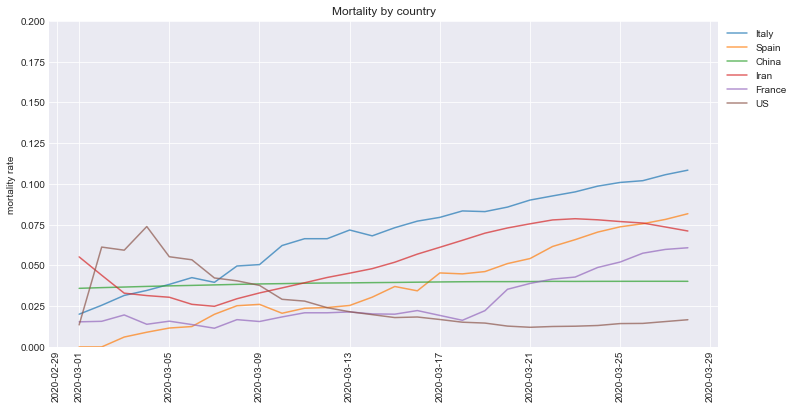

In [68]:
n_countries = 6
countries = dfp_top_countries.iloc[:n_countries]['country']

plot_mortality_rate(dfp_country, countries, upper_lim=0.2, id_col='country', date_min=datetime.datetime(2020,3,1))

### Is mortality rate a function of number of infections?

In [69]:
def plot_mortality_rate_vs_infections(
    dfp, 
    locales, 
    id_col='country', 
    upper_lim=0.2, 
    date_min=datetime.datetime(2020,2,20)
):
    
    for locale in locales:
        dfp_plot = dfp[(dfp[id_col] == locale) &
                       (dfp['date'] >= date_min)
                      ]
        plt.plot(dfp_plot['confirmed'], dfp_plot['mortality_rate'], 'o', label=locale, alpha=0.3)
    plt.legend(loc='best')
    #plt.ylim([0,upper_lim])
    plt.gca().set_ylim(top=upper_lim)
    plt.xscale('log')
    #plt.yscale('log')
    plt.xlabel('# confirmed cases')
    plt.ylabel('mortality rate')
    plt.title(f'Mortality vs confirmed cases by {id_col}')
    plt.xticks(rotation=90)
    plt.show()
    return None

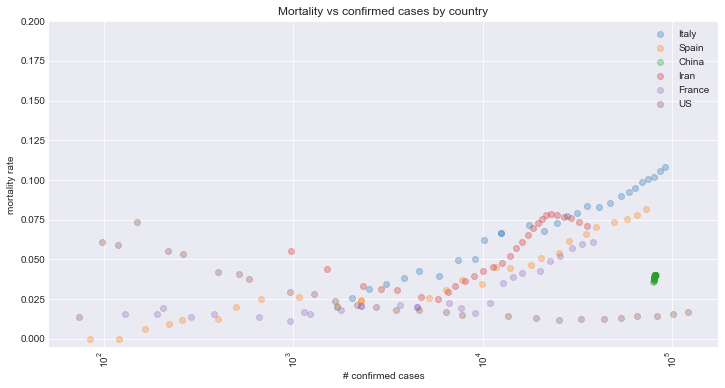

In [70]:
plot_mortality_rate_vs_infections(dfp_country, countries, upper_lim=0.2, id_col='country', date_min=datetime.datetime(2020,3,1))

# Compare mortality rate to expected given country demographics and mortality by age data?

- Country demographic data source: https://www.census.gov/data-tools/demo/idb/region.php?T=10&RT=0&A=both&Y=2020&C=AF&R=1
- Mortality by age source: https://www.worldometers.info/coronavirus/coronavirus-age-sex-demographics/

In [71]:
# mortality data
d_mortality = {0: 0, 10: 0.002, 20: 0.002, 30: 0.002, 40: 0.004, 50: 0.013, 60: 0.036, 70: 0.08, 80: 0.148, 90: 0.148, 100: 0.148}
dfp_mortality = pd.DataFrame.from_dict(d_mortality, orient='index', columns=['mortality_rate']).reset_index(drop=False)
dfp_mortality = dfp_mortality.rename(columns={'index': 'age_decade'})

# demographic data
dfp_demo = pd.read_csv('supporting_data/census_data_20200320_10a682338c.csv', skiprows=1, skipinitialspace=True)

# clean demographic data
dfp_demo = dfp_demo[(dfp_demo['Region'] == 'World') & (dfp_demo['Age'] != 'Total')]
dfp_demo['age_min'] = dfp_demo['Age'].apply(lambda x: np.min([int(y) for y in re.findall('(\d+)', x)]))
dfp_demo['age_mid'] = dfp_demo['age_min'] + 2.5
dfp_demo['age_decade'] = dfp_demo['age_min'].apply(lambda x: int(x / 10) * 10)
dfp_demo = dfp_demo.rename(columns={'Percent Both Sexes': 'pct_pop', 
                                    'Country': 'country',
                                    'Both Sexes Population': 'pop'
                                   })
dfp_demo_decade = dfp_demo.groupby(['country', 'age_decade'], as_index=False).agg({'pct_pop': np.sum, 'pop': np.sum})
dfp_demo_decade.loc[dfp_demo_decade['country'] == 'United States', 'country'] = 'US'

# join mortality with demographics
dfp_demo_decade_mortality = (dfp_demo_decade.merge(dfp_mortality, on=['age_decade'], how='inner').
                             sort_values(by=['country', 'age_decade']).
                             reset_index(drop=True)
                            )
dfp_demo_decade_mortality['frac_mortality'] = dfp_demo_decade_mortality['pct_pop'] * dfp_demo_decade_mortality['mortality_rate'] / 100
dfp_demo_decade_mortality['num_deaths_max_expected'] = dfp_demo_decade_mortality['pop'] * dfp_demo_decade_mortality['mortality_rate']
dfp_country_mortality_expected = (dfp_demo_decade_mortality.
                                  groupby(['country'], as_index=False).
                                  agg({'frac_mortality': np.sum, 
                                       'num_deaths_max_expected': np.sum, 
                                       'pop': np.sum
                                      })
                                 )
dfp_country_mortality_expected.loc[dfp_country_mortality_expected['country'] == 'United States', 'country'] = 'US'

### Age distributions for most infected countries

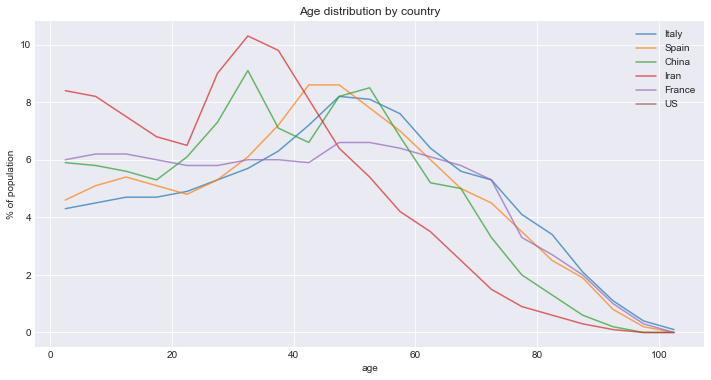

In [72]:
n_countries = 6
countries = dfp_top_countries.iloc[:n_countries]['country']
for country in countries:
    dfp_plot = dfp_demo[dfp_demo.country == country]
    plt.plot(dfp_plot['age_mid'], dfp_plot['pct_pop'], alpha=0.7, label=country)
plt.xlabel('age')
plt.ylabel('% of population')
plt.title('Age distribution by country')
plt.legend(loc='best')
plt.show()

<a id='counry_mortality_expectations'></a>
### Mortality as currently measured, compared to expected based on WHO mortality expectations

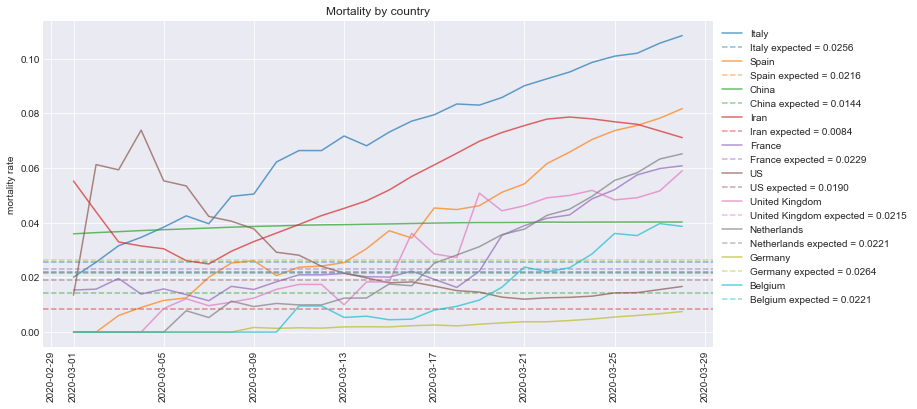

,date,country,mortality_rate,confirmed,deaths
0,2020-03-28,Italy,0.108390,92472.0,10023.0
1,2020-03-28,Spain,0.081682,73235.0,5982.0
2,2020-03-28,Iran,0.071086,35408.0,2517.0
3,2020-03-28,Netherlands,0.065180,9819.0,640.0
4,2020-03-28,France,0.060806,38105.0,2317.0
5,2020-03-28,United Kingdom,0.058976,17312.0,1021.0
6,2020-03-28,China,0.040232,81999.0,3299.0
7,2020-03-28,Belgium,0.038647,9134.0,353.0
8,2020-03-28,US,0.016678,121478.0,2026.0
9,2020-03-28,Germany,0.007505,57695.0,433.0


In [73]:
n_countries = 10
countries = dfp_top_countries.iloc[:n_countries]['country']

plot_mortality_rate(dfp_country, countries, upper_lim=None, id_col='country', date_min=datetime.datetime(2020,3,1), dfp_country_mortality_expected=dfp_country_mortality_expected)
dfp_display = (dfp_country[(dfp_country['date'] == dfp_country['date'].max()) & 
                           (dfp_country['country'].isin(countries))
                          ].
               sort_values(by='mortality_rate', ascending=0).
               reset_index(drop=True)
              )[['date', 'country', 'mortality_rate', 'confirmed', 'deaths']]
display(dfp_display)

**Remarks about the mortality rate being above the expected mortality rate**

Assuming the [cited report](https://www.worldometers.info/coronavirus/coronavirus-age-sex-demographics/) of age-wise mortality is correct and that the virus is homogeneously distributed amongst the population, a discrepancy like this could arise if the country has:
- Preferentially tested people in critical condition, ignoring test for mild cases (perhaps if testing capacity is saturated)
- An overloaded hospital system, where patients are not receiving the same quality of care they would otherwise

If the testing is biased, we can estimate the true number of infections by multiplying the confirmed cases by the ratio between the measured mortality rate and the expected mortality rate.  For example, in Iran (as of 2020-03-22), we might estimate the true number of cases is 9.3x higher using this method (200,589 vs 21,638).

### Distribution of expected mortality fractions

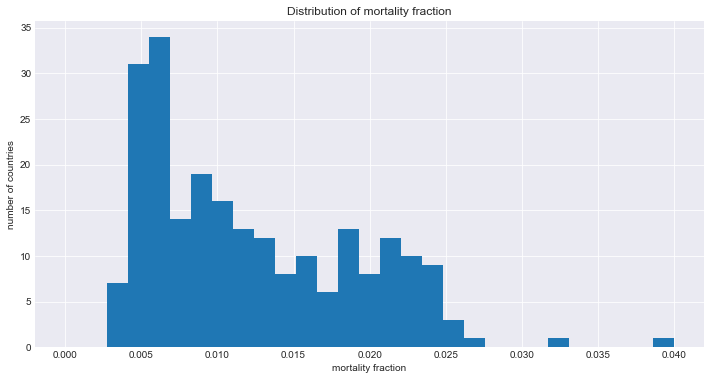

In [74]:
dfp_country_mortality_expected['frac_mortality'].hist(bins=np.linspace(0,0.04,30))
plt.title('Distribution of mortality fraction')
plt.ylabel('number of countries')
plt.xlabel('mortality fraction')
plt.show()

### Top expected mortality fractions based on age demographics
For countries with populations greater than 10 million.

In [75]:
dfp_country_mortality_expected = dfp_country_mortality_expected.sort_values(by='frac_mortality', ascending=0).reset_index(drop=True)
dfp_country_mortality_expected[dfp_country_mortality_expected['pop'] > 1E7].head(10)

,country,frac_mortality,num_deaths_max_expected,pop
1,Japan,0.031837,3998380.024,125507472
2,Germany,0.026398,2128411.026,80159662
3,Greece,0.025745,271233.247,10607051
4,Italy,0.025637,1599267.592,62402659
10,Portugal,0.023736,244829.259,10302674
18,France,0.022950,1564984.503,67848156
20,Sweden,0.022575,231555.716,10202491
23,Belgium,0.022146,259573.363,11720716
24,Netherlands,0.022076,382222.125,17280397
27,Canada,0.021712,820035.480,37694085


<a id='density_of_infections_by_country'></a>
# Density of infections per million people

In [76]:
# plot of country fractions that are infected
dfp_country_pop = dfp_country.merge(dfp_country_mortality_expected[['country', 'pop']], on='country', how='left').copy()
dfp_country_pop['deaths_per_million'] = dfp_country_pop['deaths'] / dfp_country_pop['pop'] * 1E6
dfp_country_pop['confirmed_per_million'] = dfp_country_pop['confirmed'] / dfp_country_pop['pop'] * 1E6

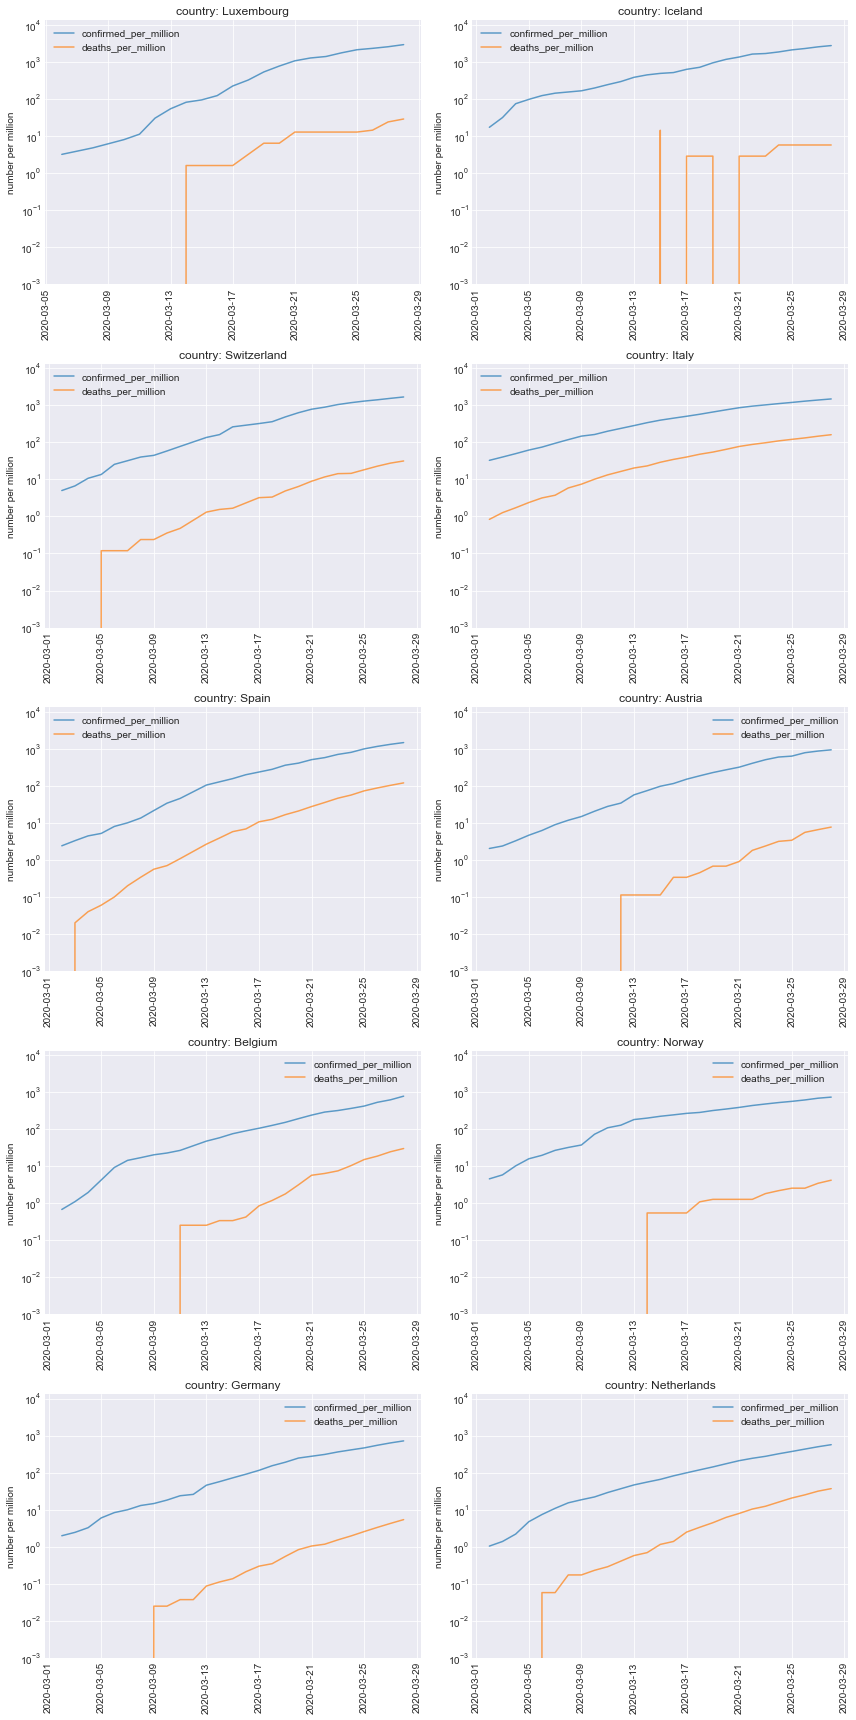

,country,population,confirmed,deaths,confirmed_per_million,deaths_per_million,mortality_rate
0,Luxembourg,628381.0,1831.0,18.0,2913.837306,28.645042,0.009831
1,Iceland,350734.0,963.0,2.0,2745.670508,5.702327,0.002077
2,Switzerland,8403994.0,14076.0,264.0,1674.917902,31.413635,0.018755
3,Italy,62402659.0,92472.0,10023.0,1481.859932,160.618156,0.108390
4,Spain,50015792.0,73235.0,5982.0,1464.237535,119.602225,0.081682
5,Austria,8859449.0,8271.0,68.0,933.579504,7.675421,0.008221
6,Belgium,11720716.0,9134.0,353.0,779.303926,30.117614,0.038647
7,Norway,5467439.0,4015.0,23.0,734.347471,4.206723,0.005729
8,Germany,80159662.0,57695.0,433.0,719.751039,5.401719,0.007505
9,Netherlands,17280397.0,9819.0,640.0,568.216112,37.036186,0.065180


In [77]:
n_countries = 10
dfp_country_pop_top = (dfp_country_pop[(dfp_country_pop['date'] == dfp_country_pop['date'].max()) &
                                       (dfp_country_pop['pop'] >= 1E5)
                                      ].
                       sort_values(by='confirmed_per_million', ascending=0).
                       reset_index(drop=True)
                      )

plot_countries(dfp_country_pop, 
               countries=dfp_country_pop_top.iloc[:n_countries]['country'],
               plot_cols=['confirmed_per_million', 'deaths_per_million'],
               country_col='country',
               y_max=dfp_country_pop['confirmed_per_million'].max()*2,
               y_min=0.001,
               y_label='number per million',
               date_min=datetime.datetime(2020,3,2)
              )
display_cols = ['country', 'pop', 'confirmed', 'deaths', 'confirmed_per_million', 'deaths_per_million', 'mortality_rate']
display(dfp_country_pop_top[display_cols].rename(columns={'pop': 'population'}).head(10))

<a id='days_behind'></a>
# How many days behind is each country from Italy?

In [78]:
def days_behind_multi_country(
    countries_compare, 
    country_base, 
    dfp=dfp_country_pop, 
    n_days=14, 
    country_col='country',
    compare_col='confirmed_frac'
):
#     country_compare = 'Spain'
#     country_base = 'Italy'
    countries = [country_base] + countries_compare
    #n_days = 14  # compare the lag over the last n_days

    # compare the fraction of cases directly
    list_dfp_compare = []
    d_dfp_compare = {}

    for i, country in enumerate(countries):
        dfp_p = dfp[dfp[country_col] == country]
        dfp_p = dfp_p.sort_values(by='date', ascending=0).reset_index(drop=True)
        
        if country == country_base:
            line_style = '-'
            dfp_comp = dfp_p.copy()
            alpha=1
        else:
            line_style = '--'
            list_dfp_compare.append(dfp_p)
            d_dfp_compare[country] = dfp_p
            alpha=0.7
        
        plt.plot(dfp_p['date'], dfp_p['confirmed'], linestyle=line_style, alpha=alpha, label=country)
        
    plt.legend(loc='best')
    plt.title('Raw number of cases')
    plt.ylabel('cases')
    plt.yscale('log')
    plt.show()


    # compute the best estimate of the lag between countries
    # this assumes that the best metric is density of cases
    # though this may be more dependent on localities
    metric = compare_col
    delta_col = f'delta_{metric}'
    list_series = []

    for country, dfp_test in d_dfp_compare.items():
        list_series = []
        delta_col = f'delta_{metric}_{country}'
        for i, row in dfp_test[:n_days].iterrows():
            dfp_comp[delta_col] = np.abs(dfp_comp[metric] - row[metric])
            min_loc = dfp_comp[delta_col] == dfp_comp[delta_col].min()
            #print(row['date'] - dfp_comp[min_loc]['date'])
            days_diff = pd.to_timedelta(row['date'] - dfp_comp[min_loc]['date']).astype('timedelta64[D]').values[0]
            row['days_diff'] = days_diff
            row['country_compare'] = country
            list_series.append(row)

        # plot days behind
        dfp_days_behind = pd.concat(list_series, axis=1).T
        plt.plot(dfp_days_behind['date'], dfp_days_behind['days_diff'], label=country, alpha=0.5)
        mean_days_diff = dfp_days_behind['days_diff'].mean()#{str(dfp['date'].max())}
        date_max = dfp['date'].max().strftime('%Y-%m-%d')
    plt.axhline(0, label='0', color='k', linestyle='--', alpha=0.5)
    #print(f'Computing how far behind a country is using the {compare_col} column:')
    plt.title(f'Number days each {country_col} is from {country_base} as of {date_max} using {compare_col}')
    plt.ylabel('# days')
    plt.legend(loc='best')
    plt.show()
    return dfp_days_behind

##### Days behind Italy via density of cases

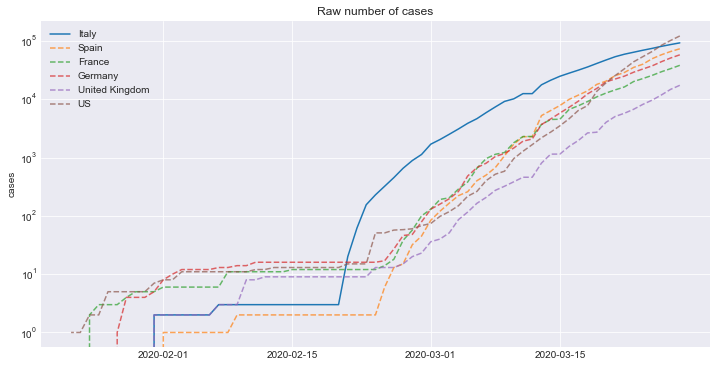

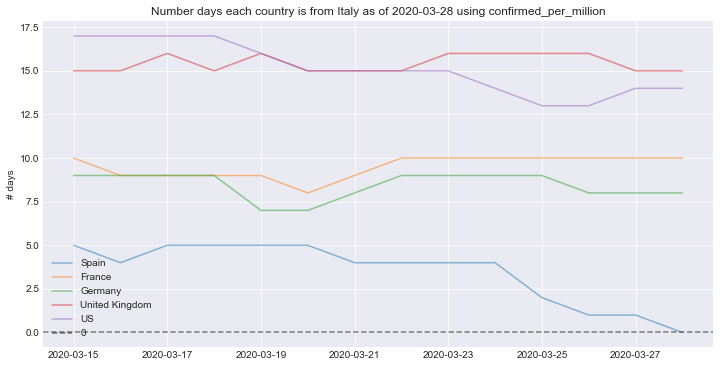

In [79]:
_ = days_behind_multi_country(['Spain', 'France', 'Germany', 'United Kingdom', 'US'], 'Italy', dfp=dfp_country_pop, compare_col='confirmed_per_million')

##### Days behind Italy via number of confirmed cases

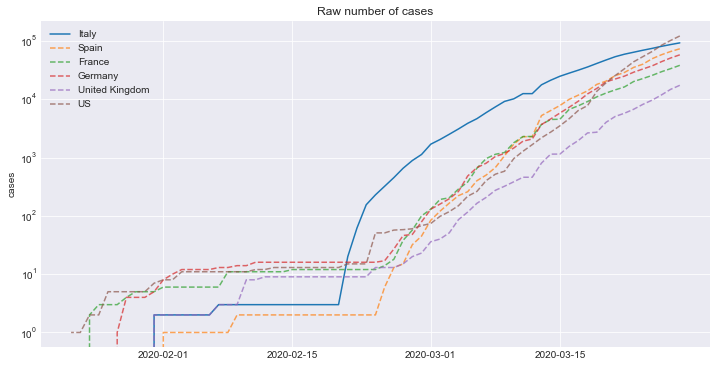

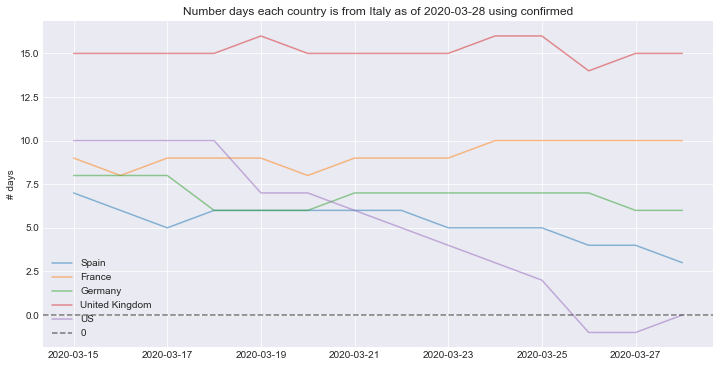

In [80]:
_ = days_behind_multi_country(['Spain', 'France', 'Germany', 'United Kingdom', 'US'], 'Italy', dfp=dfp_country_pop, compare_col='confirmed')

# US state breakdown
data source as of 2020-03-23: https://covidtracking.com/api/

In [81]:
# load and clean data
dfp_us_raw = pd.read_csv('state_data/states-daily.csv')
dfp_us_raw = dfp_us_raw.rename(columns={'state': 'state_clean_1',
                                        'positive': 'confirmed',
                                        'death': 'deaths',
                                        'date': 'date_str'
                                       })
dfp_us_raw['date'] = dfp_us_raw['date_str'].apply(lambda x: datetime.datetime.strptime(str(x), '%Y%m%d'))
dfp_us_raw['country'] = 'US'

In [82]:
# load and clean data from CSSEGIS
state_base_dir = '../COVID-19/csse_covid_19_data/csse_covid_19_daily_reports/'
data_paths_raw = os.listdir(state_base_dir)
data_paths = [path for path in data_paths_raw if path.endswith('csv')]
list_dfp_states = []
cols_of_interest = ['country', 'state', 'date', 'confirmed', 'deaths', 'recovered']
for path in data_paths:
    full_path = os.path.join(state_base_dir, path)
    
    # read state data
    dfp_temp = pd.read_csv(full_path)
    cols = list(dfp_temp.columns)
    
    # clean column names
    cols_translate = {'Country/Region': 'country',
                      'Province/State': 'state',
                      'Confirmed': 'confirmed',
                      'Deaths': 'deaths',
                      'Recovered': 'recovered',
                      'Country_Region': 'country',
                      'Province_State': 'state',
                      'Last_Update': 'Last Update'
                     }
    dfp_temp = dfp_temp.rename(columns=cols_translate)
    dfp_temp['date'] = dfp_temp['Last Update'].apply(lambda x: parser.parse(x).date())
    dfp_temp['date'] = dfp_temp['date'].apply(lambda x: datetime.datetime(x.year, x.month, x.day))
    dfp_temp = dfp_temp[dfp_temp['country'] == 'US']
    list_dfp_states.append(dfp_temp[cols_of_interest])
dfp_us_raw = pd.concat(list_dfp_states)
dfp_us_raw['state_clean_1'] = dfp_us_raw['state'].apply(lambda x: re.findall('\, ([A-Z]{2}$)', x)[0].strip() if re.findall('\, ([A-Z]{2}$)', x) else x)

In [83]:
# look only at the US
#dfp_us_raw = dfp[dfp['country'] == 'US'].copy()
#dfp_us_raw['state_clean_1'] = dfp_us_raw['state'].apply(lambda x: re.findall('\, ([A-Z]{2})', x)[0].strip() if re.findall('\, ([A-Z]{2})', x) else x)

# load codes to convert two-letter codes to state names
dfp_state_codes = pd.read_csv('supporting_data/us_state_to_two_letter_code.csv')
dfp_state_codes = dfp_state_codes.rename(columns={'state': 'state_name'})
dfp_us = dfp_us_raw.merge(dfp_state_codes, left_on=['state_clean_1'], right_on=['two_letter_code'], how='left')

In [84]:
# get the most appropriate state name
dfp_us['abbrev'] = ~dfp_us['state_name'].isnull()
dfp_us['state_clean'] = dfp_us.apply(lambda x: x['state_name'] if x['abbrev'] else x['state_clean_1'], axis=1)

# aggregate infections by state
dfp_us_g = (dfp_us.groupby(['date', 'country', 'state_clean'], as_index=False).
            agg({
                'confirmed': np.sum,
                'deaths': np.sum,
                #'recovered': np.sum,
               })
           )
dfp_us_g = dfp_us_g.sort_values(by='date')
dfp_us_g = dfp_us_g.rename(columns={'state_clean': 'state'})
#dfp_us_g['active'] = dfp_us_g['confirmed'] - dfp_us_g['recovered']
dfp_us_g['confirmed_lag1'] = dfp_us_g.groupby(['country', 'state'])['confirmed'].shift(1)
dfp_us_g['deaths_lag1'] = dfp_us_g.groupby(['country', 'state'])['deaths'].shift(1)
dfp_us_g['confirmed_new'] = dfp_us_g['confirmed'] - dfp_us_g['confirmed_lag1']
dfp_us_g['deaths_new'] = dfp_us_g['deaths'] - dfp_us_g['deaths_lag1']
dfp_us_g['mortality_rate'] = dfp_us_g['deaths'] / dfp_us_g['confirmed']

<a id='states_most_infections'></a>
### US states with the most new infections

In [85]:
id_cols_state = ['date', 'state']
value_cols_state = ['confirmed', 'confirmed_new', 'deaths', 'deaths_new', 'mortality_rate']

dfp_us_top_states = dfp_us_g[dfp_us_g['date'] == dfp_us_g['date'].max()][id_cols_state + value_cols_state]
dfp_us_top_states = dfp_us_top_states.sort_values(by='deaths', ascending=0).reset_index(drop=True)
dfp_us_top_states = dfp_us_top_states.fillna(0)
for key in value_cols_state:
    if 'rate' in key:
        continue
    dfp_us_top_states[key] = dfp_us_top_states[key].apply(int)
dfp_us_top_states.head(10)

,date,state,confirmed,confirmed_new,deaths,deaths_new,mortality_rate
0,2020-03-28,New York,52410,7534,728,201,0.013890
1,2020-03-28,Washington,4030,553,188,31,0.046650
2,2020-03-28,New Jersey,11124,2299,140,32,0.012585
3,2020-03-28,Louisiana,3315,571,137,18,0.041327
4,2020-03-28,Michigan,4650,1016,111,19,0.023871
5,2020-03-28,California,5095,438,110,16,0.021590
6,2020-03-28,Georgia,2366,366,69,5,0.029163
7,2020-03-28,Florida,3763,863,54,19,0.014350
8,2020-03-28,Illinois,3491,467,47,13,0.013463
9,2020-03-28,Massachusetts,4257,1017,44,9,0.010336


<a id='time-series_states'></a>
### Time-series plots of infections in most-infected states

In [86]:
def plot_state_data(dfp_us_g, states_oi, plot_col='confirmed', date_min=datetime.datetime(2020, 2, 25)):
    for state in states_oi:
        dfp_s = dfp_us_g[(dfp_us_g['state'] == state) & (dfp_us_g['date'] >= date_min)]
        plt.plot(dfp_s['date'], dfp_s[plot_col], label=state, alpha=0.5)
    plt.ylabel('# cases')
    plt.xticks(rotation=90)
    plt.title(f'{plot_col} in: {", ".join(states_oi)}')
    plt.yscale('log')
    plt.legend(loc='best')
    plt.show()
    return None

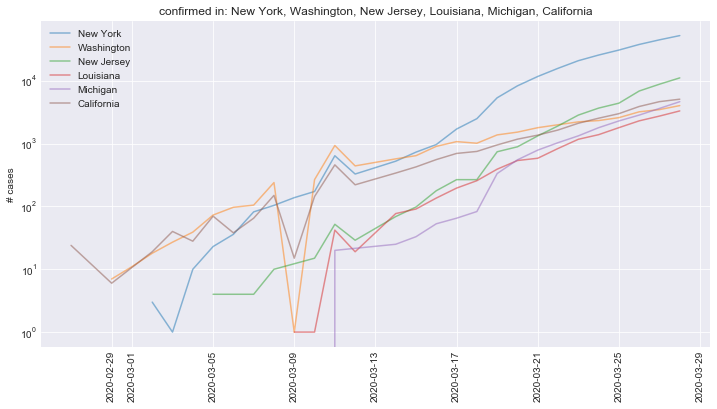

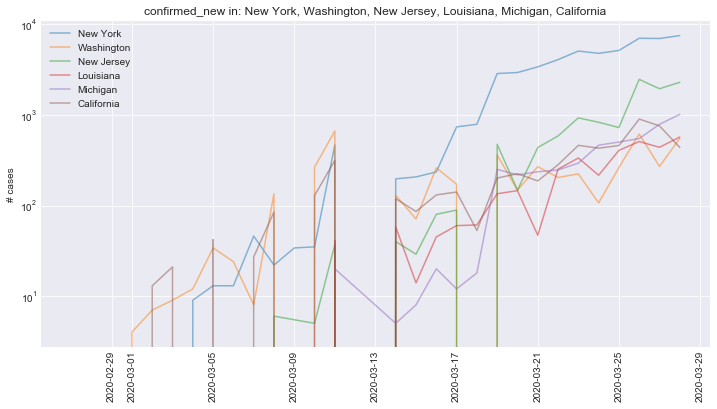

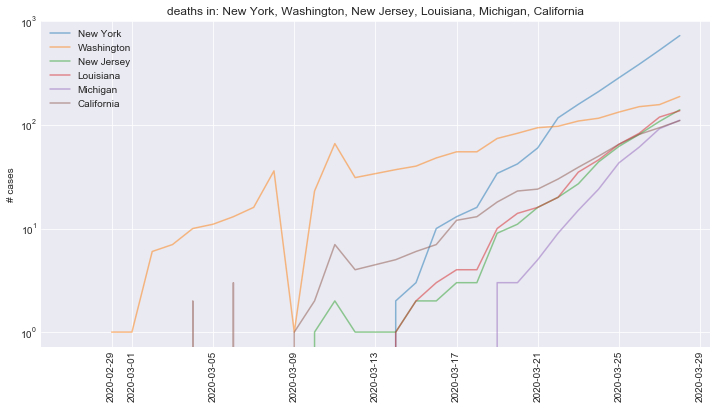

In [87]:
states_oi = dfp_us_top_states.iloc[:6]['state'].values
plot_state_data(dfp_us_g, states_oi, plot_col='confirmed')
plot_state_data(dfp_us_g, states_oi, plot_col='confirmed_new')
plot_state_data(dfp_us_g, states_oi, plot_col='deaths')

<a id='forecast_us_state'></a>
### Forecast by state

confirmed_pred                       deaths_pred             \
date              2020-03-29 2020-04-04 2020-04-18  2020-03-29 2020-04-04   
state                                                                       
New York             66559.0   217027.0  3421628.0       969.0     5989.0   
Louisiana             4339.0    16871.0   401148.0       211.0     1397.0   
New Jersey           15451.0    88996.0  5292673.0       210.0     1517.0   
Michigan              6038.0    26953.0   884095.0       205.0     2747.0   
Washington            4427.0     9024.0    47537.0       202.0      383.0   
California            6595.0    20999.0   313151.0       146.0      547.0   
Georgia               3047.0    11788.0   276907.0        86.0      269.0   
Massachusetts         6243.0    45291.0  4613684.0        67.0      586.0   
Illinois              4456.0    15510.0   284749.0        59.0      296.0   
Florida               4492.0    16949.0   375556.0        58.0      214.0   

                         mortality_rate_pred                        \
date          2020-04-18          2020-03-29 2020-04-04 2020-04-18   
state                                                                
New York        419844.0            0.014559   0.027596   0.122703   
Louisiana       114446.0            0.048629   0.082805   0.285296   
New Jersey      152503.0            0.013591   0.017046   0.028814   
Michigan       1163732.0            0.033952   0.101918   1.316297   
Washington        1694.0            0.045629   0.042442   0.035635   
California       11794.0            0.022138   0.026049   0.037662   
Georgia           3879.0            0.028224   0.022820   0.014008   
Massachusetts    89832.0            0.010732   0.012939   0.019471   
Illinois         12793.0            0.013241   0.019084   0.044927   
Florida           4489.0            0.012912   0.012626   0.011953   

              frac_increase_confirmed frac_increase_deaths  
date                                                        
state                                                       
New York                     0.217731             0.354675  
Louisiana                    0.253995             0.369794  
New Jersey                   0.338862             0.390004  
Michigan                     0.283149             0.540402  
Washington                   0.126012             0.111982  
California                   0.212898             0.245175  
Georgia                      0.252906             0.209732  
Massachusetts                0.391331             0.432382  
Illinois                     0.231048             0.308430  
Florida                      0.247695             0.242476

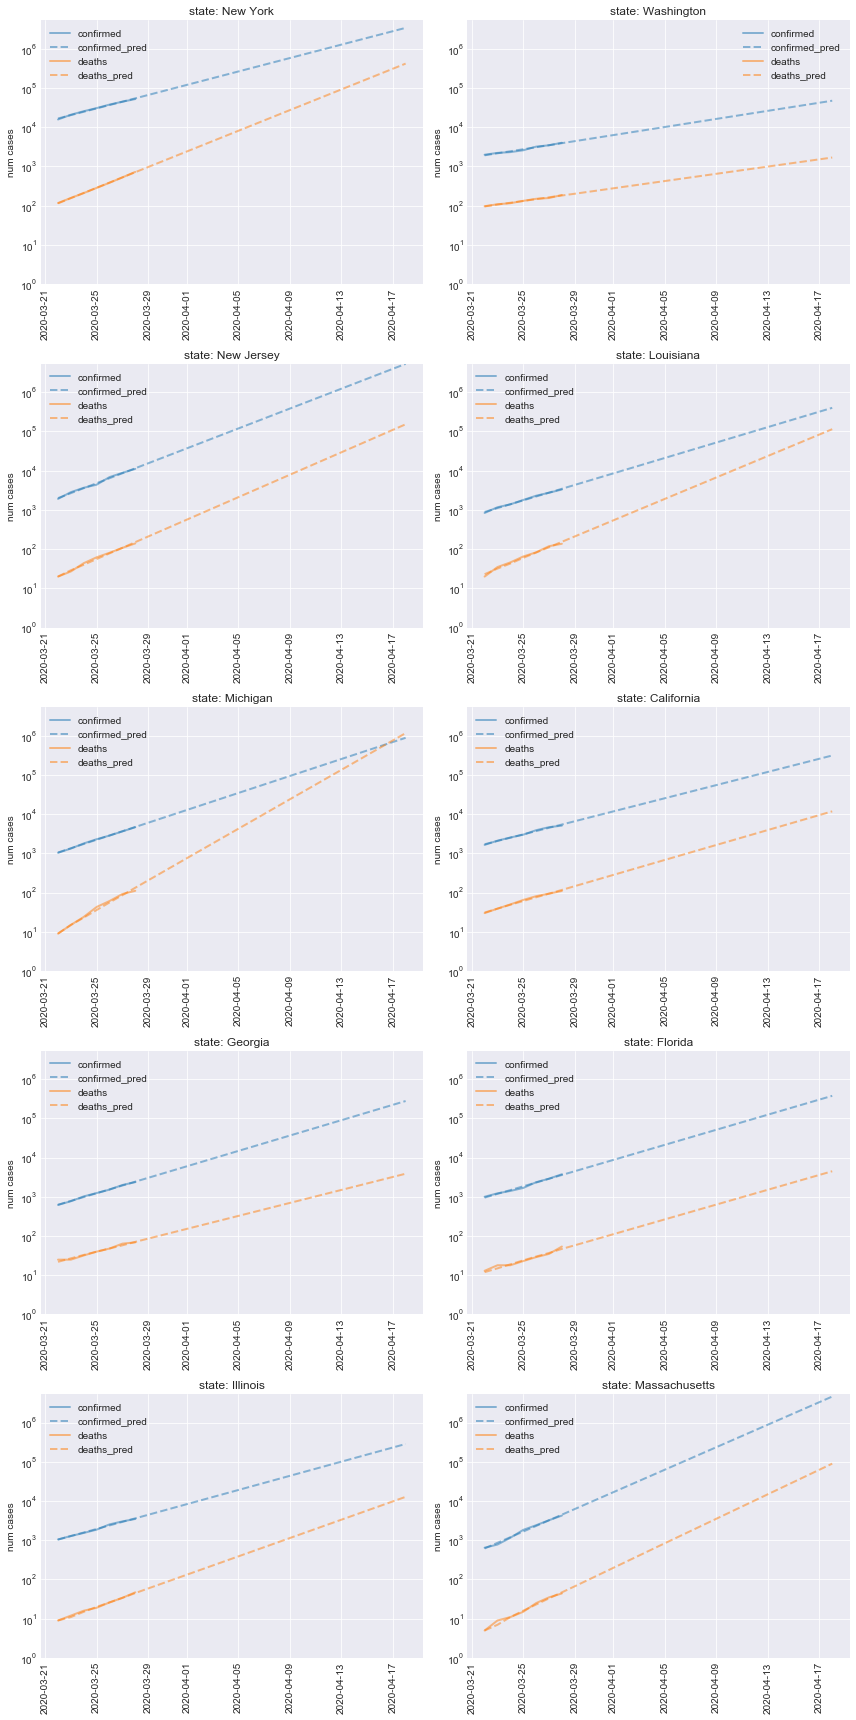

In [88]:
dfp_state_recent_1, dfp_state_forecasts_out_1 = fit_exp(dfp_us_g, 
                                                    n_days_predict=7,
                                                    n_days_into_future=[1,7,21],
                                                    col_locale='state', 
                                                    top_countries=None
                                                   )
plot_forecasts(dfp_state_recent_1, 
                   n_countries=10, 
                   n_columns=2, 
                   figsize=(12,24), 
                   date_min=datetime.datetime(2020, 2, 1),
                   col_locale='state',
                  )

<a id='us_state_daily_increase_fraction'></a>
##### States and their daily increase fraction in confirmed cases/deaths
Computed via linear fit of the log of the confirmed cases/deaths over the last 7 days.

In [89]:
# what is the distribution in % increase in deaths?
dfp_state_increase = (dfp_state_forecasts_out_1[(dfp_state_forecasts_out_1['date'] == dfp_state_forecasts_out_1['date'].max()) &
                                                (dfp_state_forecasts_out_1['deaths_pred'] > 2)
                                               ].
                      sort_values(by='frac_increase_deaths', ascending=0).
                      reset_index(drop=True)
                     )
dfp_state_increase[['state', 'frac_increase_confirmed', 'frac_increase_deaths']]

,state,frac_increase_confirmed,frac_increase_deaths
0,Mississippi,0.221215,0.627978
1,Michigan,0.283149,0.540402
2,Arizona,0.302648,0.442487
3,Massachusetts,0.391331,0.432382
4,Pennsylvania,0.341533,0.420573
5,Oklahoma,0.368931,0.412222
6,Ohio,0.258227,0.393691
7,New Jersey,0.338862,0.390004
8,Louisiana,0.253995,0.369794
9,North Carolina,0.232968,0.364376


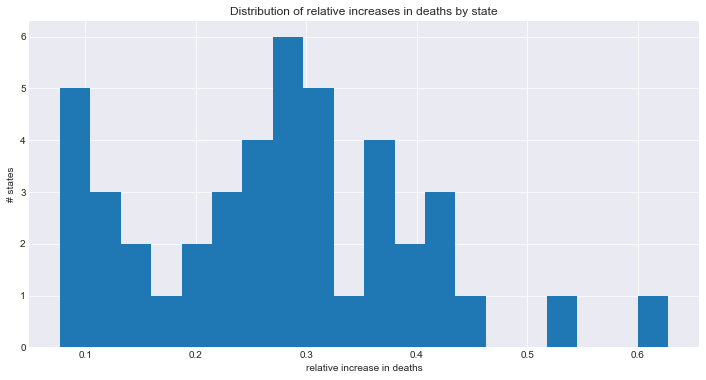

In [90]:
dfp_state_increase['frac_increase_deaths'].hist(bins=20)
plt.xlabel('relative increase in deaths')
plt.ylabel('# states')
plt.title('Distribution of relative increases in deaths by state')
plt.show()

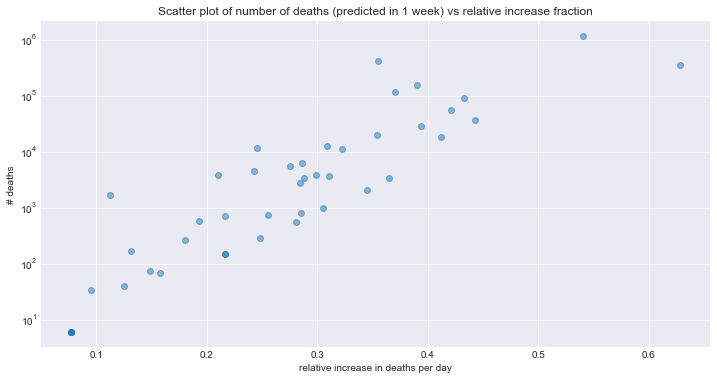

In [91]:
plt.plot(dfp_state_increase['frac_increase_deaths'], dfp_state_increase['deaths_pred'], 'o', alpha=0.5)
#plt.xscale('log')
plt.yscale('log')
plt.xlabel('relative increase in deaths per day')
plt.ylabel('# deaths')
plt.title('Scatter plot of number of deaths (predicted in 1 week) vs relative increase fraction')
plt.show()

<a id='state_infections_vs_wa'></a>
##### Compare US state infections against Washington

In [92]:
dfp_us_g = dfp_us_g[~(dfp_us_g['date']==datetime.datetime(2020,3,9))]

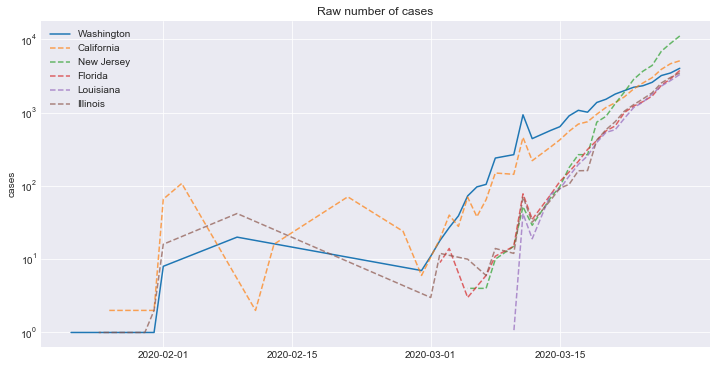

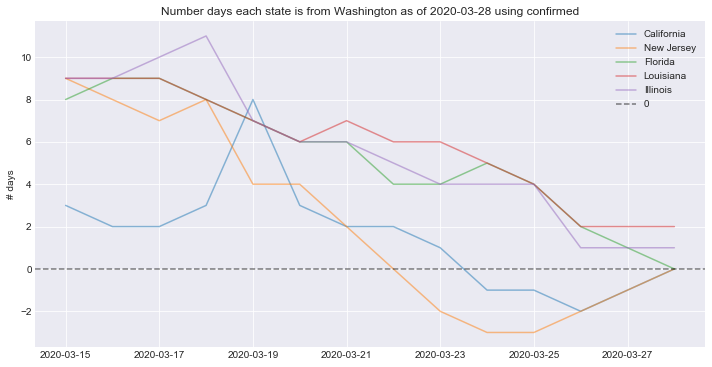

In [93]:
_ = days_behind_multi_country(['California', 'New Jersey', 'Florida', 'Louisiana', 'Illinois'], 
                              'Washington', 
                              dfp=dfp_us_g, 
                              country_col='state', 
                              compare_col='confirmed'
                             )

<a id='state_infections_vs_ny'></a>
##### Compare US state infections against New York

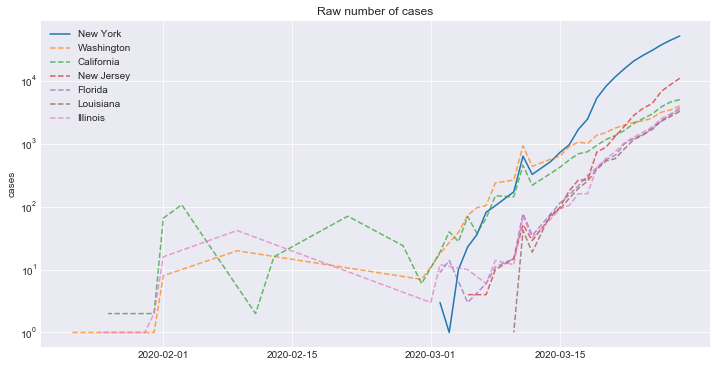

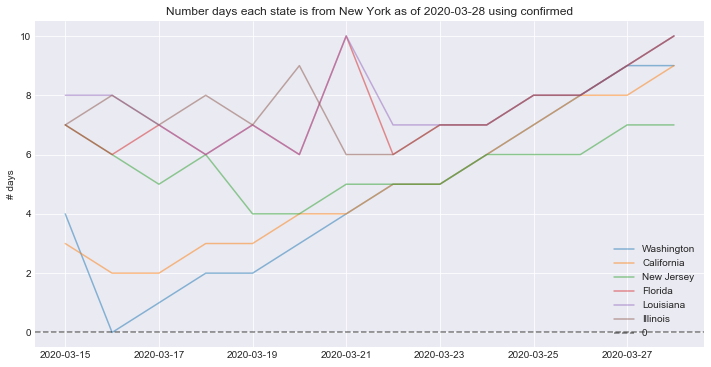

In [94]:
_ = days_behind_multi_country(['Washington', 'California', 'New Jersey', 'Florida', 'Louisiana', 'Illinois'], 
                              'New York', 
                              dfp=dfp_us_g, 
                              country_col='state', 
                              compare_col='confirmed'
                             )

<a id='mortality_by_us_state'></a>
### Mortality rate by US state

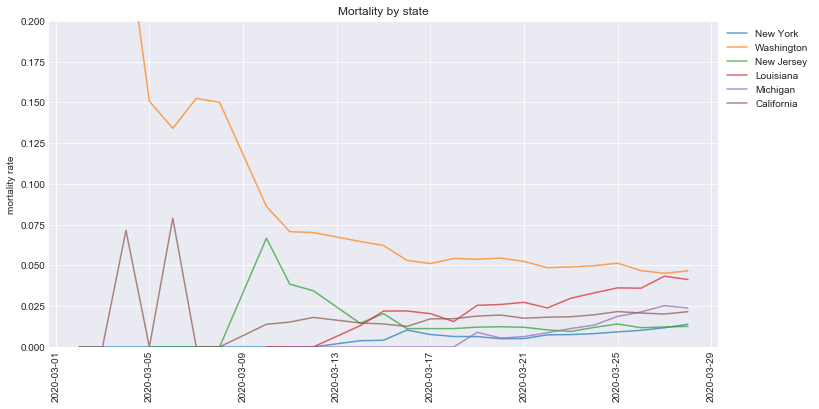

In [95]:
n_states = 6
states = dfp_us_top_states.iloc[:n_states]['state']

plot_mortality_rate(dfp_us_g, states, upper_lim=0.2, id_col='state', date_min=datetime.datetime(2020,3,2))

##### Relationship between mortality rate and number of cases

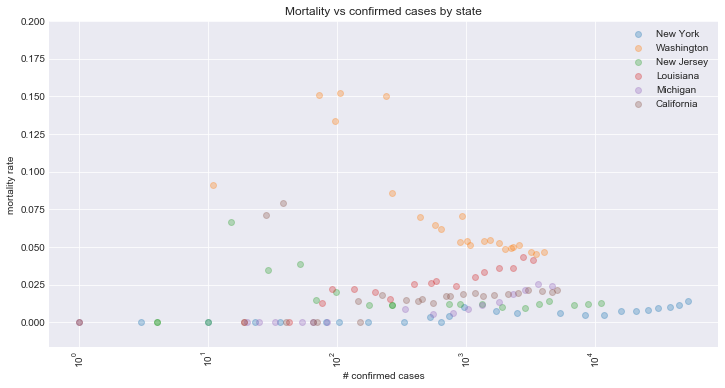

In [96]:
plot_mortality_rate_vs_infections(dfp_us_g, states, upper_lim=0.2, id_col='state', date_min=datetime.datetime(2020,3,1))

<a id='us_state_relative_increases'></a>
### Relative increases per day by state

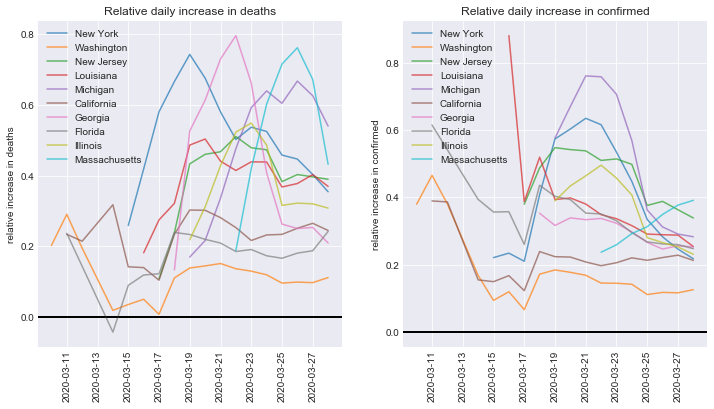

In [97]:
find_relative_increase_data_and_plot(dfp_us_g, n_locales=10, col_locale='state')